# Generic examples

## Plot examples

In [1]:
import numpy as np
import pandas as pd

from utils import plot, plot_multiple, load_json, ThreadPool

datas = {
    'm1' : np.linspace(0, 1, 10),
    'm2' : np.linspace(1, 0.5, 10)
}
random_datas = {
    'dist_1' : np.random.normal(size = 10000),
    'dist_2' : np.random.uniform(size = 10000)
}

dataframe = pd.DataFrame([
    {'a' : 5, 'b' : 3, 'c' : 1},
    {'a' : 4, 'b' : 3, 'c' : 1},
    {'a' : 6, 'b' : 5, 'c' : 2},
    {'a' : 6, 'b' : 4, 'c' : 2},
    {'a' : 3, 'b' : 2, 'c' : 2},
])

plot(datas, title = 'Example of plot')
plot_multiple(** datas, title = 'Example of subplot', xlabel = 'x', ylabel = 'y', ylim = (0,1),
              use_subplots = True, horizontal = True,
              filename = 'example_data/plots/plot_simple_example.png')
plot_multiple(** random_datas, title = 'Example of histogram', use_subplots = True, 
              xlabel = 'x', ylabel = 'frequency', plot_type = 'hist', horizontal = True,
              filename = 'example_data/plots/plot_hist_example.png', show = True)
plot_multiple(dataframe, by = 'c', title = 'Example of dataframe plot',
              use_subplots = True, horizontal = True, show = True,
              filename = 'example_data/plots/plot_dataframe_example.png')
plot_multiple(dataframe, corr = 'c', title = 'Example of dataframe correlation plot',
              use_subplots = True, horizontal = True, show = True,
              filename = 'example_data/plots/plot_dataframe_corr_example.png')

<Figure size 640x480 with 1 Axes>

<Figure size 600x300 with 2 Axes>

<Figure size 600x300 with 2 Axes>

<Figure size 600x300 with 2 Axes>

## Embeddings examples

Note : the provided embeddings are samples from the VoxForge dataset embedded by my AudioSiamese model : `audio_siamese_256_mel_lstm` (will be released later)

Original embeddings :
                                              filename                                          embedding  \
0    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00011343794, -0.00012576704, 0.0004697689,...   
1    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00029487943, -0.00019367959, 0.0008462651,...   
2    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00012839596, -1.3334279e-05, 0.001058621, ...   
3    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00031986443, -0.00041395996, 0.000898958, ...   
4    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00027184433, -0.00063498016, 0.00038204438...   
5    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00024186505, -5.275228e-05, 0.0021878968, ...   
6    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00032492177, -4.1103354e-05, 0.0027732619,...   
7    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00040969707, -0.0003298011, 0.0009261206, ... 

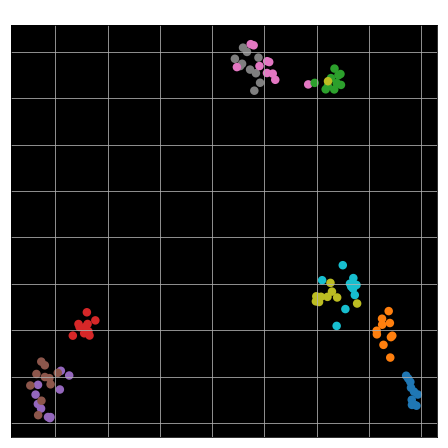

In [6]:
from utils import plot_embedding, set_display_options
from utils.embeddings import load_embedding
from utils.pandas_utils import sample_df, aggregate_df

set_display_options(rows = 25, width = 125)

directory = 'example_data'
filename = 'embeddings_{}_voxforge.csv'

embeddings = load_embedding(directory, embedding_dim = 256, embedding_name = filename)

print("Original embeddings :")
print(embeddings)

print("Count for each id")
print(aggregate_df(embeddings, 'id', 'filename', count = len))

samples = sample_df(embeddings) # get 10 embeddings for 10 different speakers

print("Samples to plot :")
print(samples)

plot_embedding(samples, filename = 'example_data/plots/plot_embeddings.png')

## Other examples

`load_json` and `dump_json` are utilities functions to load / save json data.

They can be useful for 2 reasons : 
1. Make in 1 line a 3-line code :D
2. Avoid errors in loading / saving datas which can lead to a data destruction.

Indeed, if your json file is not well formatted, having a `JsonParserError` while loading the file can destroy the file. The 2 functions converts data to `json` format before / after saving / loading them to not have the error when the file is open.

In [7]:
from utils import load_json

filename = 'example_data/stft_config.json'
config = load_json(filename)
config

{'class_name': 'TacotronSTFT',
 'filter_length': 1024,
 'hop_length': 256,
 'win_length': 1024,
 'n_mel_channels': 80,
 'sampling_rate': 22050,
 'mel_fmin': 0.0,
 'mel_fmax': 8000.0,
 'normalize_mode': None}